In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.2 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf
import shutil
import os
from scipy import interpolate
import pandas as pd

dde.config.set_random_seed(666)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Formulation of the Problem
Modified system of equations can be written as follows:

\begin{gather*}
\frac{dv}{dt} = A \\
\frac{dA}{dt} = \kappa(v_o - v) - \alpha\left(\frac{aA}{v} + \frac{b}{\theta}\left(1 - \frac{v\theta}{L}\right)\right) \\
\frac{d\theta}{dt} = 1 - \frac{v\theta}{L}
\end{gather*}


In [3]:
alpha = 9.81
kappa = 1
v0 = 1
a = 0.2
b = 0.3
L =  0.25

In [4]:
def ode_system(x, y):
  v = y[:, 0:1]
  A = y[:, 1:2]
  theta = y[:, 2:3]

  dv_t = dde.grad.jacobian(y, x, i=0)
  dA_t = dde.grad.jacobian(y, x, i=1)
  dtheta_t = dde.grad.jacobian(y, x, i=2)

  return   [
      dv_t - A,
      dA_t - kappa * (v0 - v) + alpha * (a/v*A + b/theta*(1-v*theta/L)),
      dtheta_t - 1 + v*theta/L ]

# Define Training Function
`train_deepxde` is the training function for each time step. It takes number of residual points, time, initial values of $v$, $A$, and $\theta$. The default traininf has 4 layer of 64 neurons, Adam optimizer with learning rate 0.001. We train for 30,000 iterations





In [5]:
def train_deepxde(num_res, tmax, v0, A0, theta0):
  def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]

    return tf.concat(
        [y1 * tf.tanh(t) + v0, y2 * tf.tanh(t) + A0, y3 * tf.tanh(t) + theta0], axis=1
    )
  geom = dde.geometry.TimeDomain(0, tmax)
  data = dde.data.PDE(geom, ode_system,[], num_res, 0, num_test = 30000)
  layer_size = [1] + [64] * 4 + [3]
  activation = "tanh"
  initializer = "Glorot normal"
  net = dde.nn.FNN(layer_size, activation, initializer)
  net.apply_output_transform(output_transform)
  model = dde.Model(data, net)
  model.compile("adam", lr=0.001)
  checker = dde.callbacks.ModelCheckpoint(
      "Model/model"+str(count)+"/model.ckpt", save_better_only=True, period=50
  )
  losshistory, train_state = model.train(iterations=30000, callbacks=[checker])

  if losshistory.steps[-1] != 30000:
    model, train_state = train_deepxde(num_res, tmax, v0, A0, theta0)

  else:
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    model.restore("Model/model"+str(count)+"/model.ckpt-" + str(train_state.best_step)+'.ckpt', verbose=1)
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

  return model, train_state

# Train Adaptive Time Stepping with Loss Tolerance
We train the model and inspect minimum loss. If minimum loss is greater than the tolerance, we bisect time step and train the model again. If not, the model proceed to the next step.

Compiling model...
Building feed-forward neural network...
'build' took 0.080527 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.420633 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.68e-01, 1.10e+01, 1.93e-03]    [8.68e-01, 1.10e+01, 1.93e-03]    []  
1000      [6.35e-04, 1.82e-03, 8.24e-05]    [6.35e-04, 1.82e-03, 8.23e-05]    []  
2000      [2.92e-04, 9.11e-04, 3.71e-05]    [2.92e-04, 9.10e-04, 3.71e-05]    []  
3000      [5.46e-05, 3.06e-04, 2.80e-05]    [5.46e-05, 3.05e-04, 2.80e-05]    []  
4000      [2.95e-05, 1.23e-04, 2.36e-05]    [2.95e-05, 1.23e-04, 2.35e-05]    []  
5000      [4.04e-05, 1.13e-04, 2.89e-05]    [4.03e-05, 1.13e-04, 2.89e-05]    []  
6000      [1.72e-05, 8.26e-05, 1.66e-05]    [1.72e-05, 8.25e-05, 1.65e-05]    []  
7000      [1.61e-05, 7.85e-05, 1.96e-05]    [1.61e-05, 7.84e-05, 1.96e-05]    []  
8000      [1.75e-05, 8.04e-05, 2.35e-05]    [1.75e-05, 8.03e-05, 2.35e-05]    []  
9000      [1.65e-05, 7.16e-05, 2.41e-05]    [1.65e-05, 7.15e-05, 2.41e-05]    []  
10000     [1.61e-05, 6.20e-05, 2.4

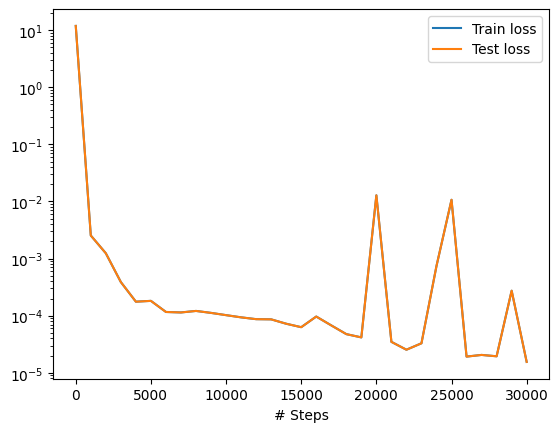

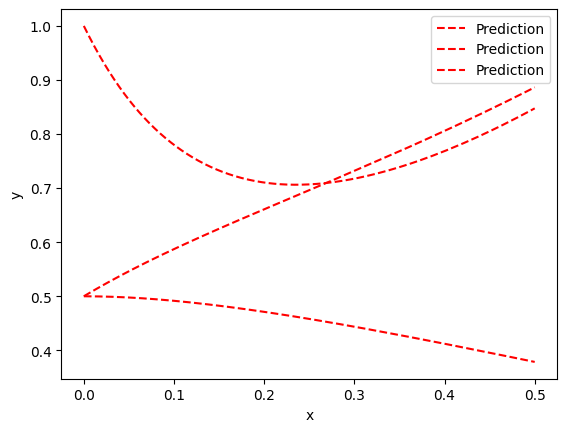

Restoring model from Model/model0/model.ckpt-30000.ckpt ...

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


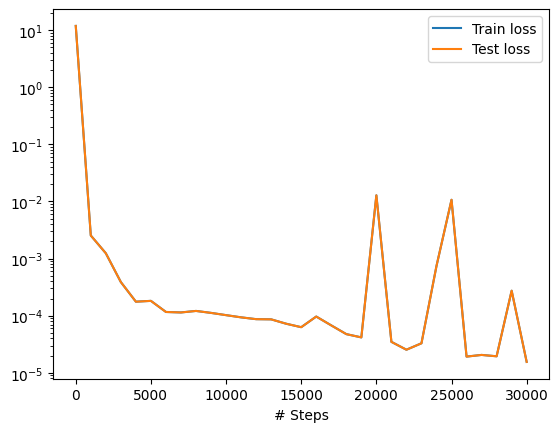

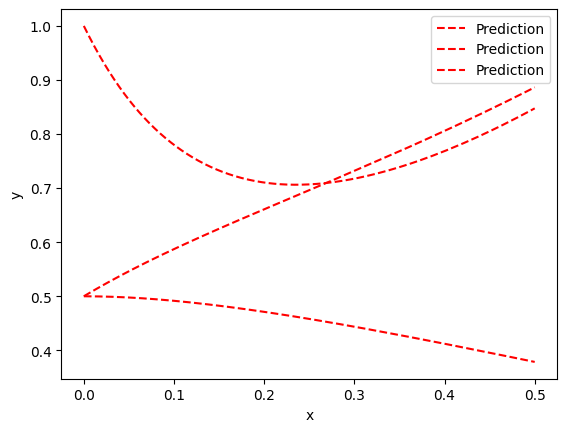

Compiling model...
Building feed-forward neural network...
'build' took 0.068166 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.868595 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.75e-01, 6.28e-01, 5.52e-02]    [5.75e-01, 6.28e-01, 5.52e-02]    []  
1000      [1.44e-03, 5.65e-04, 2.04e-04]    [1.44e-03, 5.65e-04, 2.04e-04]    []  
2000      [1.25e-03, 3.48e-04, 2.40e-04]    [1.25e-03, 3.48e-04, 2.39e-04]    []  
3000      [1.12e-03, 2.24e-04, 2.74e-04]    [1.12e-03, 2.24e-04, 2.74e-04]    []  
4000      [1.05e-03, 2.47e-04, 2.38e-04]    [1.05e-03, 2.47e-04, 2.38e-04]    []  
5000      [8.77e-04, 1.84e-04, 2.45e-04]    [8.77e-04, 1.84e-04, 2.45e-04]    []  
6000      [1.97e-04, 1.05e-04, 1.69e-04]    [1.97e-04, 1.05e-04, 1.69e-04]    []  
7000      [1.05e-05, 3.42e-05, 9.02e-05]    [1.05e-05, 3.42e-05, 9.02e-05]    []  
8000      [7.98e-06, 1.26e-05, 3.40e-05]    [7.98e-06, 1.26e-05, 3.40e-05]    []  
9000      [3.64e-06, 6.99e-06, 4.08e-06]    [3.64e-06, 6.98e-06, 4.08e-06]    []  
10000     [1.82e-06, 9.26e-06, 3.2

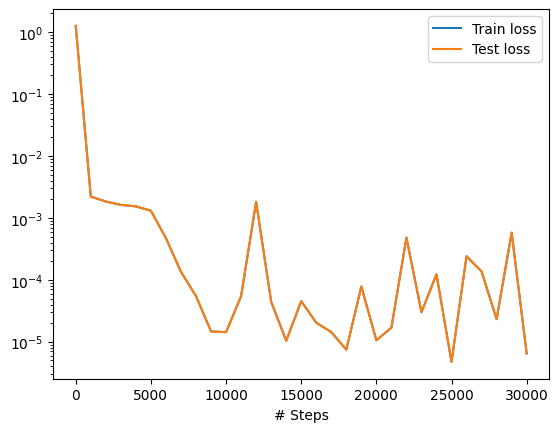

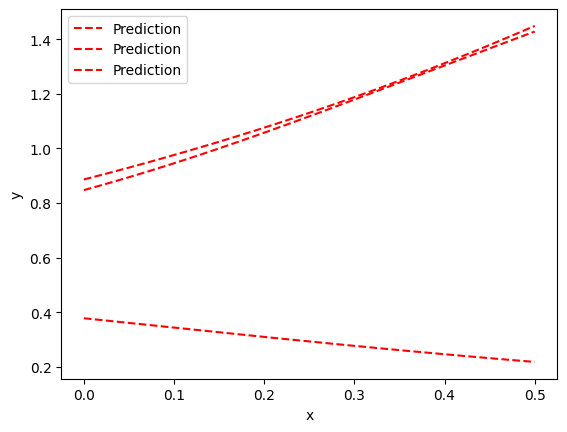

Restoring model from Model/model1/model.ckpt-25000.ckpt ...

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


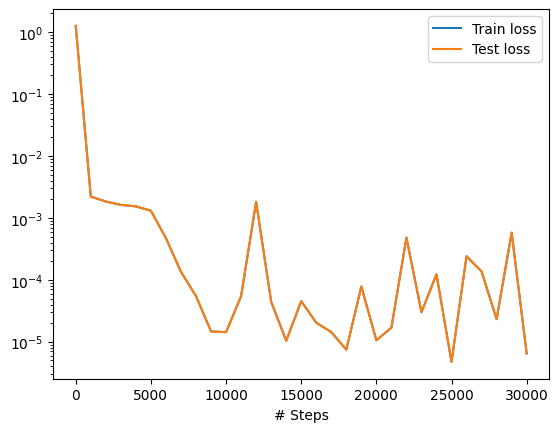

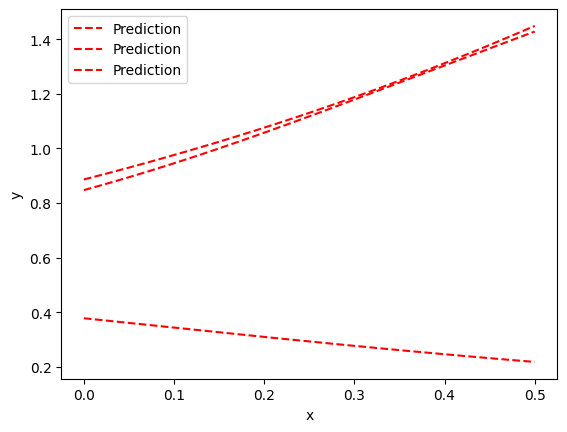

In [6]:
tol = 0.0001
tmax = 0.5
num_res = 100000

t_values = []
v_values = []
A_values = []
theta_values = []
t_log = []
v_log = []
A_log = []
theta_log = []

t = 0
v, A, theta = 0.5, 1, 0.5
count = 0


while t <= tmax:
  t_values.append(t)
  v_values.append(v)
  A_values.append(A)
  theta_values.append(theta)
  h = 0.5

  loss_min = 100
  while loss_min > tol:
    model, train_state = train_deepxde(num_res, h, v, A, theta)
    loss_min = train_state.best_loss_train

    h = h/2

  t_test = np.linspace(0, 2*h, 1000).reshape(1000, 1)
  t1 = np.linspace(t, t+2*h, 1000)
  pred1 = model.predict(t_test)
  v1 = pred1[:,0].reshape(-1)
  A1 = pred1[:,1].reshape(-1)
  theta1 = pred1[:,2].reshape(-1)

  v = v1[-1]
  A = A1[-1]
  theta = theta1[-1]
  t += h*2
  count += 1

  t_log.append(t1)
  v_log.append(v1)
  A_log.append(A1)
  theta_log.append(theta1)

  dic1 = {'t_train': np.array(t_log).reshape(-1), 'pred_v': np.array(v_log).reshape(-1), 'pred_A': np.array(A_log).reshape(-1), 'pred_t': np.array(theta_log).reshape(-1)}
  dic2 = {'t_step': np.array(t_values).reshape(-1), 'v_step': np.array(v_values).reshape(-1), 'A_step': np.array(A_values).reshape(-1), 'theta_step': np.array(theta_values).reshape(-1)}

  df1 = pd.DataFrame(dic1)
  df2 = pd.DataFrame(dic2)

  df1.to_csv('Prediction/pred_'+str(t)+'.csv')
  df2.to_csv('Prediction/pred_step_'+str(t)+'.csv')

